In [2]:
import anndata
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd

from scbasset.utils import *

### download the pre-processed data and trained model

In [1]:
import subprocess
import os

download_savepath = '../../data/download'
os.makedirs(download_savepath, exist_ok=True)

if not os.path.exists('%s/pbmc_multiome_ad.h5ad'%download_savepath):
    subprocess.run('wget -P %s https://storage.googleapis.com/scbasset_tutorial_data/pbmc_multiome_ad.h5ad'%download_savepath, shell=True)

if not os.path.exists('%s/pbmc_multiome_best_model.h5'%download_savepath):
    subprocess.run('wget -P %s https://storage.googleapis.com/scbasset_tutorial_data/pbmc_multiome_best_model.h5'%download_savepath, shell=True)

if not os.path.exists('%s/pbmc_multiome_train_test_val.h5'%download_savepath):
    subprocess.run('wget -P %s https://storage.googleapis.com/scbasset_tutorial_data/pbmc_multiome_train_test_val.h5'%download_savepath, shell=True)


### load the data

In [5]:
ad_file = '../../data/download/pbmc_multiome_ad.h5ad'
trained_model = '../../data/download/pbmc_multiome_best_model.h5'
h5_file = '../../data/download/pbmc_multiome_train_test_val.h5'

In [ ]:
os.makedirs("results", exist_ok=True)

# read h5ad file
ad = anndata.read_h5ad(ad_file)

# load model
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights(trained_model)

### intercept vs. depth

/home/yuanh/programs/anaconda3/envs/scbasset/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


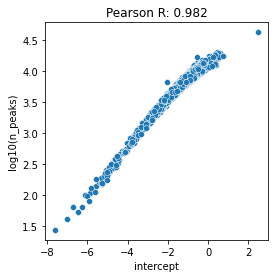

In [7]:
intercept = get_intercept(model) # get_intercept function
sc.pp.filter_cells(ad, min_counts=0)

f, ax = plt.subplots(figsize=(4,4))
r = scipy.stats.pearsonr(intercept, np.log10(ad.obs['n_genes']))[0]
sns.scatterplot(intercept, np.log10(ad.obs['n_genes']), ax=ax)
ax.set_xlabel('intercept')
ax.set_ylabel('log10(n_peaks)')
ax.set_title('Pearson R: %.3f'%r)
f.savefig('results/intercept.pdf')

### cell embeddings

/home/yuanh/programs/anaconda3/envs/scbasset/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


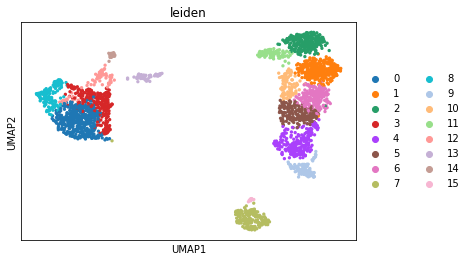

In [8]:
proj = get_cell_embedding(model) # get_cell_embedding function
pd.DataFrame(proj).to_csv('results/projection_atac.csv')

ad.obsm['projection'] = pd.read_csv('results/projection_atac.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.umap(ad)
sc.tl.leiden(ad)
sc.pl.umap(ad, color='leiden')

### imputation

In [9]:
f = h5py.File(h5_file, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

Y_norm = imputation_Y_normalize(X, model)